In [1]:
import requests
import pandas as pd

# API endpoint for Our World in Data COVID-19 dataset
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"

# Fetching the data
response = requests.get(url)

# Save to a local CSV file (optional)
with open("owid-covid-data.csv", "wb") as file:
    file.write(response.content)

# Load the data into a pandas DataFrame
data = pd.read_csv("owid-covid-data.csv")
print(data.head())


  iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-01-05          0.0        0.0   
1      AFG      Asia  Afghanistan  2020-01-06          0.0        0.0   
2      AFG      Asia  Afghanistan  2020-01-07          0.0        0.0   
3      AFG      Asia  Afghanistan  2020-01-08          0.0        0.0   
4      AFG      Asia  Afghanistan  2020-01-09          0.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           0.0         0.0                  NaN  ...   
1                 NaN           0.0         0.0                  NaN  ...   
2                 NaN           0.0         0.0                  NaN  ...   
3                 NaN           0.0         0.0                  NaN  ...   
4                 NaN           0.0         0.0                  NaN  ...   

   male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
0           NaN            

In [2]:
!pip install pyspark


In [3]:
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder \
    .appName("COVID Analysis") \
    .getOrCreate()

# Verify Spark version
print(f"Using Apache Spark version: {spark.version}")


Using Apache Spark version: 3.5.3


In [4]:
# Load CSV into Spark DataFrame
df = spark.read.csv("owid-covid-data.csv", header=True, inferSchema=True)

# Display schema and sample data
df.printSchema()
df.show(5)


root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: date (nullable = true)
 |-- total_cases: integer (nullable = true)
 |-- new_cases: integer (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: integer (nullable = true)
 |-- new_deaths: integer (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: integer (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: integer (nullable = true)
 |-- hosp_patients_per_mil

In [5]:
from pyspark.sql.functions import col

# Add cases per 100k and vaccination rate columns
df = df.withColumn("cases_per_100k", (col("total_cases") / col("population")) * 100000) \
       .withColumn("vaccination_rate", (col("total_vaccinations") / col("population")) * 100)

# Filter for low-performing countries
low_cases_threshold = 50  # cases per 100k
low_vax_threshold = 20  # %

low_perf_countries = df.filter((col("cases_per_100k") < low_cases_threshold) &
                               (col("vaccination_rate") < low_vax_threshold))

# Display filtered data
low_perf_countries.select("location", "cases_per_100k", "vaccination_rate").show(10)


+--------+------------------+-------------------+
|location|    cases_per_100k|   vaccination_rate|
+--------+------------------+-------------------+
|  Brunei| 46.10224453343192|                0.0|
|  Brunei| 46.10224453343192| 0.1679279825034187|
|  Brunei|47.661257633596286|0.18307268119072967|
|  Brunei|47.661257633596286|0.27037741479993405|
|  Brunei|47.661257633596286| 0.5701533623458248|
|  Brunei|47.661257633596286| 0.7113554059892829|
|  Brunei|47.661257633596286| 0.8966552487516759|
|  Brunei|47.661257633596286| 0.9668108382590723|
|  Brunei|47.661257633596286| 1.1198168382323463|
|  Brunei| 48.77483841942798|  1.145874628620808|
+--------+------------------+-------------------+
only showing top 10 rows



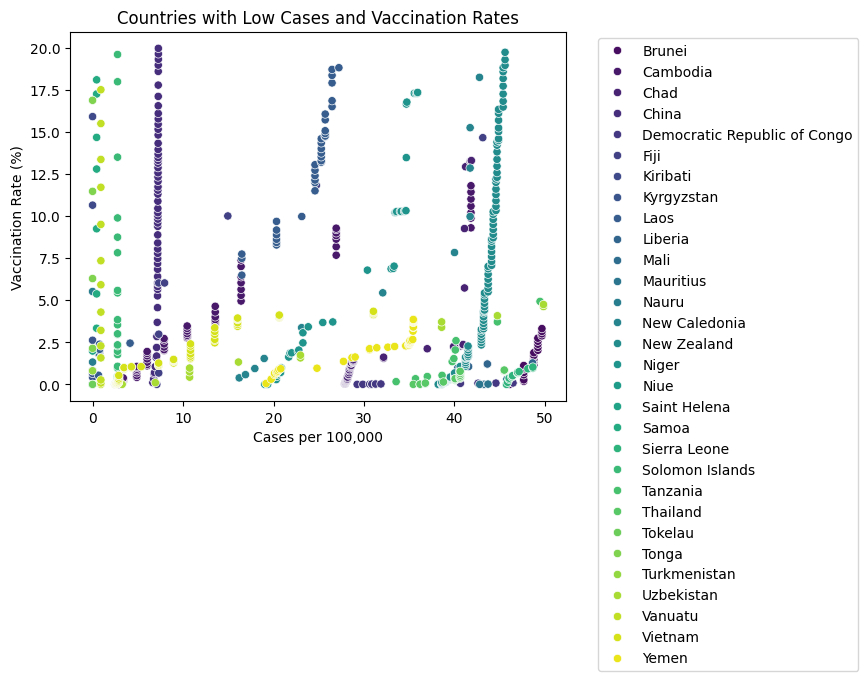

In [6]:
# Convert to Pandas DataFrame
low_perf_countries_pd = low_perf_countries.toPandas()

# Visualize using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    x="cases_per_100k",
    y="vaccination_rate",
    hue="location",
    data=low_perf_countries_pd,
    palette="viridis"
)
plt.title("Countries with Low Cases and Vaccination Rates")
plt.xlabel("Cases per 100,000")
plt.ylabel("Vaccination Rate (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [7]:
!pip install pyspark pandas matplotlib seaborn plotly folium geopandas requests streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.5 MB/s eta 0:00:00


In [8]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Prepare data for clustering
features = ["cases_per_100k", "vaccination_rate"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
cluster_data = assembler.transform(low_perf_countries)

# Apply KMeans
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(cluster_data)
clusters = model.transform(cluster_data)

clusters.select("location", "features", "prediction").show()


+--------+--------------------+----------+
|location|            features|prediction|
+--------+--------------------+----------+
|  Brunei|[46.1022445334319...|         1|
|  Brunei|[46.1022445334319...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[49.2202707337606...|         1|
|  Brunei|[49.2202707337606...|         1|
|  Brunei|[49.2202707337606...|         1|
|  Brunei|[49.2202707337606...|         1|
+--------+-

In [9]:
from pyspark.ml.regression import LinearRegression

# Prepare data for regression
assembler = VectorAssembler(inputCols=["cases_per_100k"], outputCol="features")
regression_data = assembler.transform(low_perf_countries).select("features", col("vaccination_rate").alias("label"))

# Train-Test Split
train, test = regression_data.randomSplit([0.8, 0.2], seed=42)

# Train the model
lr = LinearRegression(featuresCol="features", labelCol="label")
model = lr.fit(train)

# Test the model
predictions = model.transform(test)
predictions.select("features", "label", "prediction").show()


+--------------------+--------------------+------------------+
|            features|               label|        prediction|
+--------------------+--------------------+------------------+
|               [0.0]|0.009712514106898886| 4.294391680619708|
|               [0.0]|   0.650421732745696| 4.294391680619708|
|               [0.0]|  2.0447255242005236| 4.294391680619708|
| [0.677337881502261]|  1.8042288992980522| 4.302862161583199|
|[2.8268380963070343]|0.002021725980270...|4.3297428383440195|
| [2.856657063567657]| 0.07256147493199934|  4.33011574085166|
|[3.3874346808067415]|   0.324132174122969| 4.336753405487659|
| [4.890310630742127]|   0.519261532083032| 4.355547691872736|
| [6.029395180097914]|    1.69904897174957|   4.3697925676646|
| [6.029395180097914]|  1.8378801195215775|   4.3697925676646|
| [6.029395180097914]|   1.951651407207757|   4.3697925676646|
|[6.7553723177684954]|  0.3155929511851483| 4.378871309150207|
| [6.848507304251578]|  0.7013176693003296| 4.380036013

In [10]:
import datetime

# Generate a daily summary
today = datetime.date.today()
report = low_perf_countries.select("location", "cases_per_100k", "vaccination_rate").toPandas()
report.to_csv(f"daily_report_{today}.csv", index=False)

print(f"Report generated for {today}")


Report generated for 2024-12-18


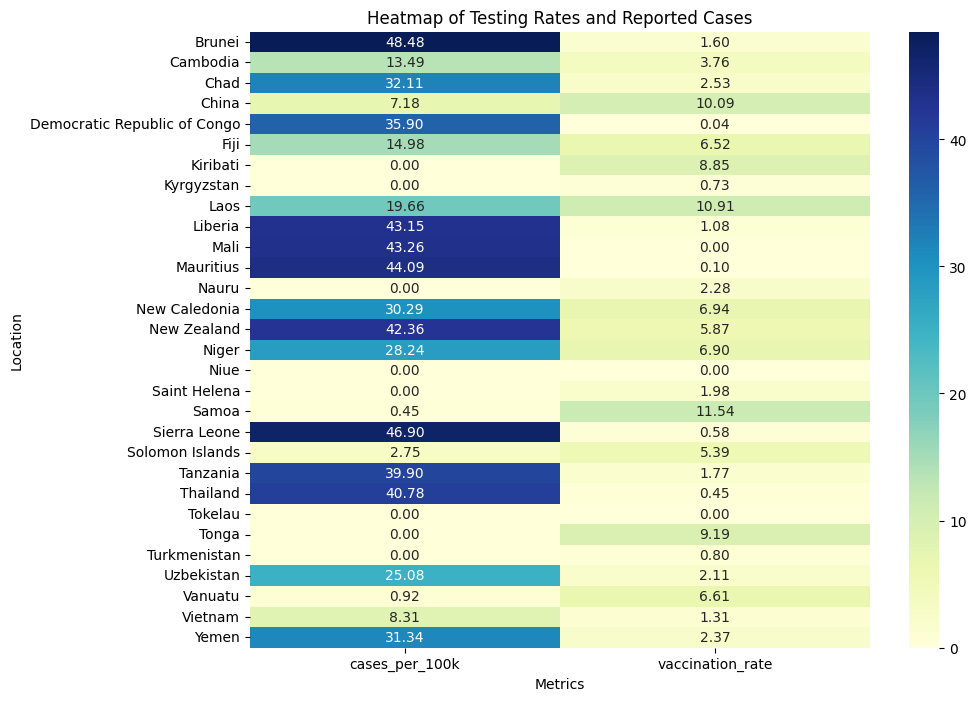

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'low_perf_countries_pd' DataFrame from the previous code is available

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(low_perf_countries_pd.pivot_table(index='location',
                                             values=['cases_per_100k', 'vaccination_rate'],
                                             aggfunc='mean'),
            annot=True, fmt=".2f", cmap="YlGnBu") # Use appropriate colormap
plt.title("Heatmap of Testing Rates and Reported Cases")
plt.xlabel("Metrics")
plt.ylabel("Location")
plt.show()

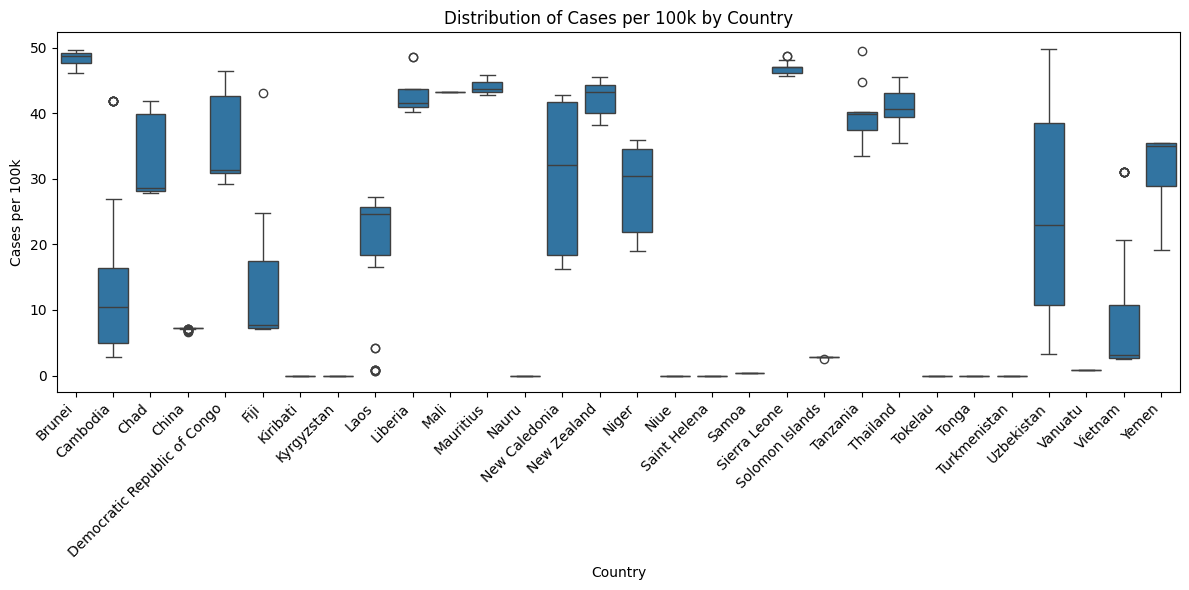

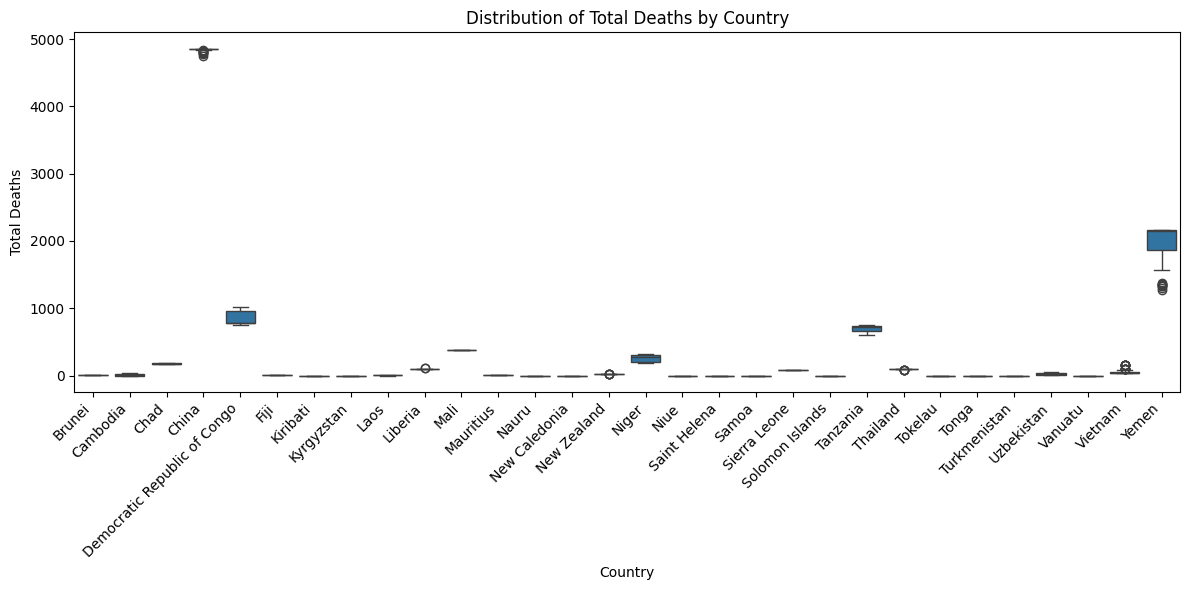

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='location', y='cases_per_100k', data=low_perf_countries_pd)
plt.title('Distribution of Cases per 100k by Country')
plt.xlabel('Country')
plt.ylabel('Cases per 100k')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(x='location', y='total_deaths', data=low_perf_countries_pd)
plt.title('Distribution of Total Deaths by Country')
plt.xlabel('Country')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

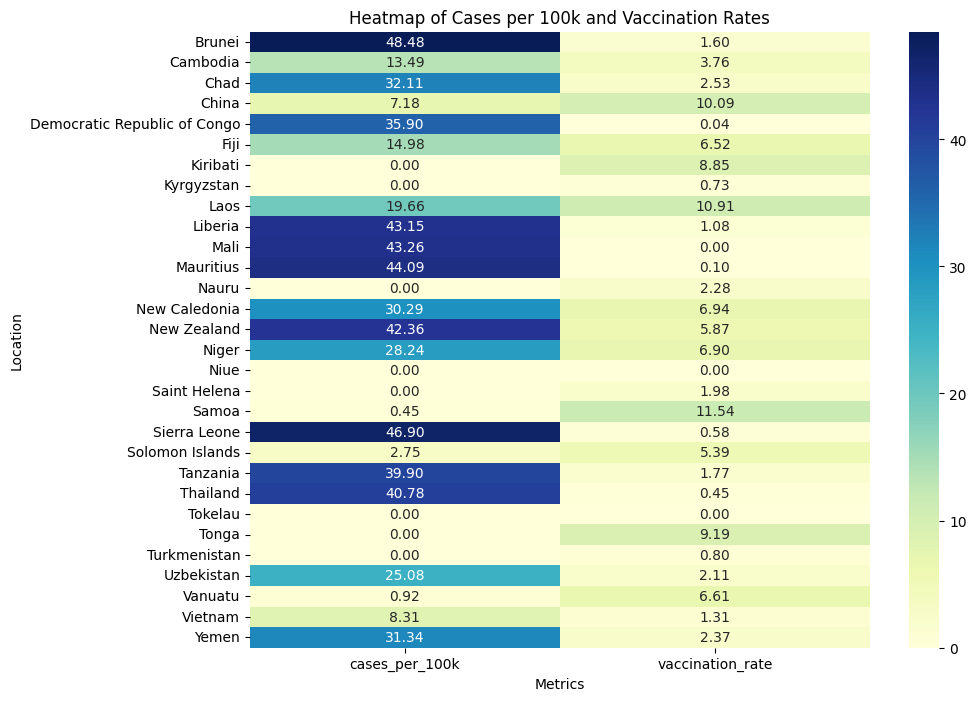

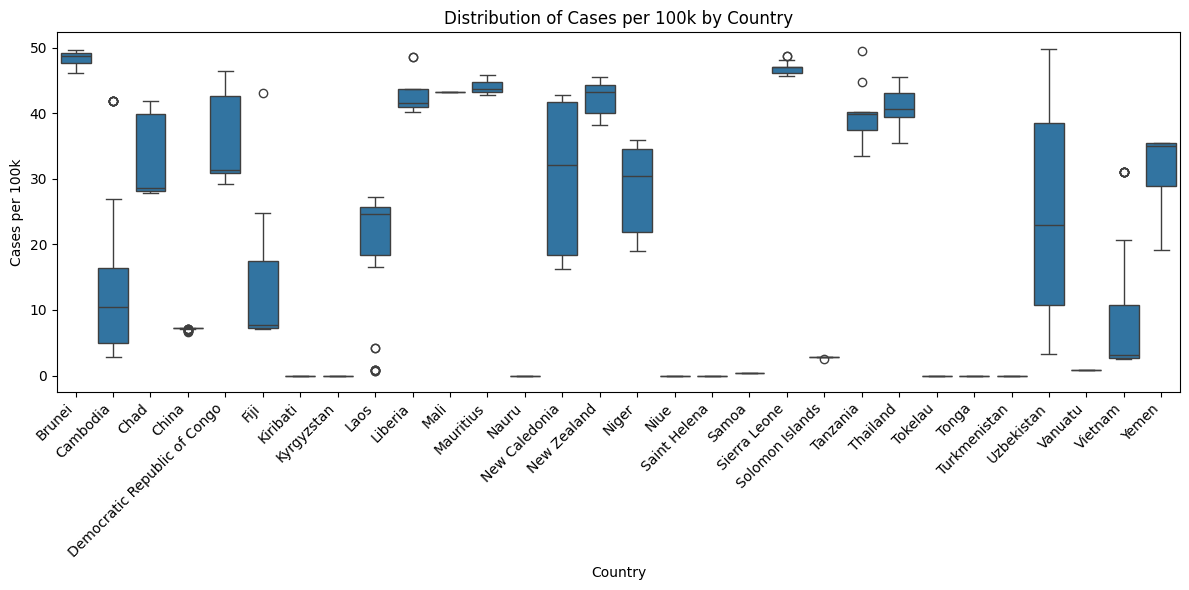

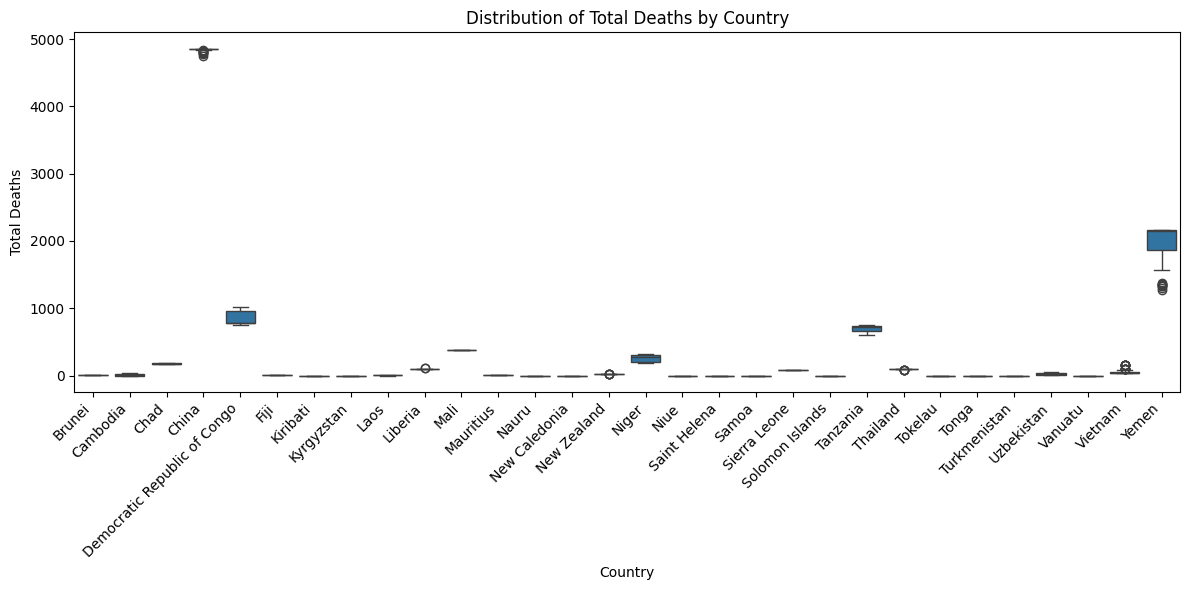

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(low_perf_countries_pd.pivot_table(index='location',
                                             values=['cases_per_100k', 'vaccination_rate'],
                                             aggfunc='mean'),
            annot=True, fmt=".2f", cmap="YlGnBu") # Use appropriate colormap
plt.title("Heatmap of Cases per 100k and Vaccination Rates")
plt.xlabel("Metrics")
plt.ylabel("Location")
plt.show()

# Create the boxplot for cases_per_100k
plt.figure(figsize=(12, 6))
sns.boxplot(x='location', y='cases_per_100k', data=low_perf_countries_pd)
plt.title('Distribution of Cases per 100k by Country')
plt.xlabel('Country')
plt.ylabel('Cases per 100k')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Create the boxplot for total_deaths (if the column exists in your data)
if 'total_deaths' in low_perf_countries_pd.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='location', y='total_deaths', data=low_perf_countries_pd)
    plt.title('Distribution of Total Deaths by Country')
    plt.xlabel('Country')
    plt.ylabel('Total Deaths')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Warning: 'total_deaths' column not found in the DataFrame. Skipping the total deaths boxplot.")

In [14]:
# Prepare data for clustering (using the existing low_perf_countries DataFrame)
features = ["cases_per_100k", "vaccination_rate"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
cluster_data = assembler.transform(low_perf_countries)

# Apply KMeans clustering
kmeans = KMeans(k=3, seed=1)  # You can adjust the number of clusters (k) as needed
model = kmeans.fit(cluster_data)
clusters = model.transform(cluster_data)

# Show the clustering results
clusters.select("location", "features", "prediction").show()

# You can further analyze the clusters by grouping and aggregating data
clusters.groupBy("prediction").agg({"cases_per_100k": "avg", "vaccination_rate": "avg"}).show()

+--------+--------------------+----------+
|location|            features|prediction|
+--------+--------------------+----------+
|  Brunei|[46.1022445334319...|         1|
|  Brunei|[46.1022445334319...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[47.6612576335962...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[48.7748384194279...|         1|
|  Brunei|[49.2202707337606...|         1|
|  Brunei|[49.2202707337606...|         1|
|  Brunei|[49.2202707337606...|         1|
|  Brunei|[49.2202707337606...|         1|
+--------+-

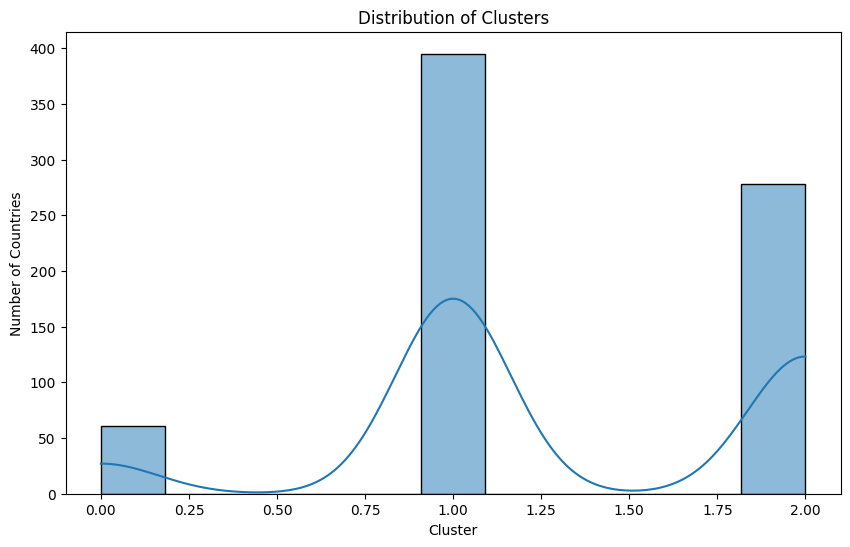

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


# Convert the Spark DataFrame to a Pandas DataFrame for easier plotting
clusters_pd = clusters.toPandas()

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(clusters_pd['prediction'], kde=True)  # Use 'prediction' column for the histogram
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Countries')
plt.show()

In [18]:
import plotly.express as px

# Create the choropleth map
fig = px.choropleth(clusters_pd, locations="location",
                    locationmode="country names",
                    color="prediction",  # Color by cluster prediction
                    hover_name="location", # Show country name on hover
                    hover_data=["cases_per_100k", "vaccination_rate"], # Add more data to display on hover
                    title="COVID-19 Clusters by Country")
fig.show()

In [19]:
!pip install plotly folium geopandas

import plotly.express as px
import pandas as pd

# Filter out locations with NaN values in 'cases_per_100k' or 'vaccination_rate'
filtered_clusters = clusters_pd.dropna(subset=['cases_per_100k', 'vaccination_rate'])

fig = px.choropleth(filtered_clusters,
                    locations="location",
                    locationmode="country names",
                    color="prediction",  # Color by cluster prediction
                    hover_name="location",
                    hover_data=["cases_per_100k", "vaccination_rate"],
                    title="COVID-19 Clusters by Country",
                    color_continuous_scale='Viridis') # Choose a color scale

# Show the map
fig.show()


# Find countries with no information reported (NaN values)
no_info_countries = clusters_pd[clusters_pd['cases_per_100k'].isnull() | clusters_pd['vaccination_rate'].isnull()]
print("\nCountries with no information reported:")
print(no_info_countries[['location', 'cases_per_100k', 'vaccination_rate']])


# Generate the map for countries with no information
if not no_info_countries.empty:
  fig_no_info = px.choropleth(no_info_countries, locations="location",
                              locationmode="country names",
                              color= "location",  # Color by location to highlight them
                              hover_name="location",
                              title="Countries with Missing Data")
  fig_no_info.show()
else:
  print("No countries with missing data found.")


Countries with no information reported:
Empty DataFrame
Columns: [location, cases_per_100k, vaccination_rate]
Index: []
No countries with missing data found.
